Сильченко А.Е. группа 201-361
## Лабораторная работа №3.5
# Обработка малоразмерных изображений с помощью МНС
**Вариант 1** - Kuzushiji-MNIST Unown-MNIST https://github.com/lopeLH/unown-mnist

In [1]:
# Импортируйте PyTorch и необходимые модули для работы с фреймворком
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Загрузите данные
X, Y = np.load("X_train.npy"), np.load("Y_train.npy") #загрузка признаков и меток
#разбиение данных 20% валидационные данные 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42) 
X_test, Y_test = np.load("X_test.npy"), np.load("Y_test.npy")

# Создаем объекты TensorDataset
# оборачивает тензоры данных и меток в один объект.
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

# Создайте объекты DataLoader для ваших выборок
batch_size = 64 # Задается размер батча (количество примеров данных, обрабатываемых за один шаг).
train_dataloader =  DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
#Создаются объекты DataLoader для каждого набора данных. 
# DataLoader упрощает итерацию по данным во время обучения, позволяя легко загружать данные пакетами (батчами) 
# и применять различные техники управления данными, такие как перемешивание и многопоточная загрузка.

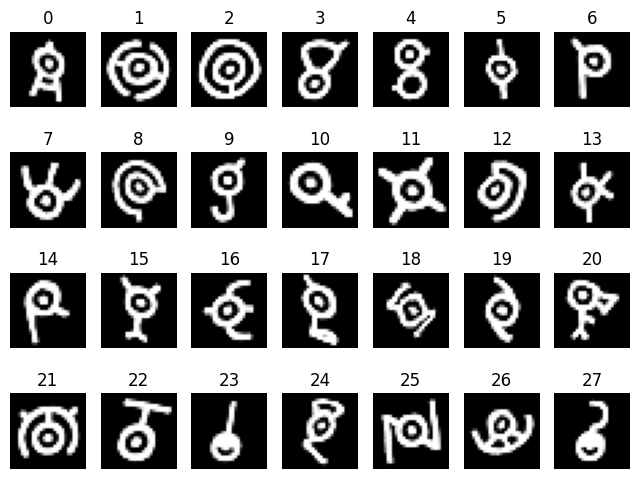

In [3]:
# Визуализация набора данных
index = 0
plt.figure(figsize=(8, 6))
for i in range(7):
    for j in range(4):
        ax = plt.subplot(4, 7, 4*i+j+1)
        ax.imshow(X[np.where(Y == index)[0][0]], cmap="gray", interpolation=None)
        plt.title(Y[np.where(Y == index)[0][0]])
        index += 1
        ax.axis('off')

In [ ]:
# Напишите ответ какого ранга тензор, содержащий 1 пакет ваших данных и укажите размерности этого тензора

for batch in train_dataloader:
    images, labels = batch

    print("Ранг тензора:", torch.Tensor(X_train).ndim)
    print("Размерность тензора:", torch.Tensor(X_train).shape)

    break

In [4]:
# Код для получения доступных устройств
# device = тип устройства, наилучшим образом подходящего для вычислений.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    #Если CUDA-устройство недоступно, код проверяет, доступно ли устройство с поддержкой MPS 
    # (Metal Performance Shaders) — это API от Apple для ускорения вычислений на GPU в устройствах Apple.
    if torch.backends.mps.is_available()  # если не доступно ни одно, то CPU (центральный процессор) как устройство для вычислений.
    else "cpu"
)
print(f"Используется {device}")

Используется cpu


In [5]:
# Напишите вашу реализацию NeuralNetwork для нейронной сети
# Не забудьте преобразовать ваши данные в одномерный тензор с помощью flatten()

# специально делаю плохую модель, чтобы потом её улучшить
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Создает слой Flatten, который преобразует входные данные в одномерный тензор. to(device) переносит этот слой на выбранное устройство (CPU, GPU или MPS).
        self.flatten = nn.Flatten().to(device)
        self.model = nn.Sequential(
            #первый линейный слой, преобразует в 512 признаков
            nn.Linear(28*28, 512).to(device),
            # функция активации Sigmoid, она помогает модели учиться на сложных или нелинейных данных.
            nn.Sigmoid().to(device),
            nn.Linear(512, 256).to(device),
            nn.Sigmoid().to(device),
            nn.Linear(256, 28).to(device), # предсказывает 28 разных классов    
        )

    # Это метод, который определяет, как данные проходят через сеть (прямое распространение).
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

In [6]:
# Создание экземпляра нейронной сети и перемещение ее на устройство
model = NeuralNetwork().to(device)

# Перемещение данных (батчей и меток) на устройство
for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

# Вывод модели
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=28, bias=True)
  )
)


In [7]:
# Определение функции потерь

loss_fn = F.cross_entropy # используется для задачи классификации многих классов
# Она используется для измерения разницы между предсказанными вероятностями классов и истинными метками классов.

# Определение оптимизатора и скорости обучения
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Этот оптимизатор обновляет веса модели в процессе обучения, используя градиенты функции потерь.

# Количество эпох для обучения
epochs = 3

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Переключим модель в режим обучния
    model.train()
    loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Вычислите предсказание, потери и метрики точности
        # Сохраните значение потерь и точности для построения графика
        pred = model(X)
        y = y.long()
        loss = loss_fn(pred, y)
        # Обратное распространение ошибки, не забудьте обнулить градиенты
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (pred.argmax(dim=-1) == y).type(torch.float).sum().item() # Рассчитывает количество правильных предсказаний

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]") 

    return loss.item(), correct / size # возвращает значение последней потери loss и точность модели на обучающих данных


def test_loop(dataloader, model, loss_fn):
    # Переключим модель в режим оценки
    model.eval() # Это гарантирует, что слои, влияющие на режим обучения (например, Dropout), не будут воздействовать на результаты оценки.
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Оценка модели в контексте torch.no_grad() гарантирует, что в тестовом режи
    with torch.no_grad():
        for X, y in dataloader:
            # Напишите код для расчета предсказаний, потерь и метрики точности
            # Сохраните значение потерь и точности для построения графика
            pred = model(X)
            y = y.long()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=-1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") # Функция выводит информацию о точности и средней потере на тестовых данных.

    return test_loss, correct



In [9]:
# цикл обучения и оценки модели на протяжении нескольких эпох.
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(val_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc.append(train_correct)
    test_losses.append(test_loss)
    test_acc.append(test_correct)


Epoch 1
-------------------------------
loss: 3.357777  [   64/48000]
loss: 3.365030  [ 6464/48000]
loss: 3.366640  [12864/48000]
loss: 3.307092  [19264/48000]
loss: 3.291743  [25664/48000]
loss: 3.280404  [32064/48000]
loss: 3.292848  [38464/48000]
loss: 3.281348  [44864/48000]
Test Error: 
 Accuracy: 24.8%, Avg loss: 3.270223 

Epoch 2
-------------------------------
loss: 3.260520  [   64/48000]
loss: 3.264533  [ 6464/48000]
loss: 3.252292  [12864/48000]
loss: 3.243955  [19264/48000]
loss: 3.238176  [25664/48000]
loss: 3.227475  [32064/48000]
loss: 3.229886  [38464/48000]
loss: 3.222750  [44864/48000]
Test Error: 
 Accuracy: 72.6%, Avg loss: 3.210568 

Epoch 3
-------------------------------
loss: 3.201709  [   64/48000]
loss: 3.205781  [ 6464/48000]
loss: 3.189506  [12864/48000]
loss: 3.190342  [19264/48000]
loss: 3.184806  [25664/48000]
loss: 3.171919  [32064/48000]
loss: 3.171638  [38464/48000]
loss: 3.164922  [44864/48000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 3.152809 



loss: 3.142331  [   64/48000]
loss: 3.149699  [ 6464/48000]
loss: 3.134260  [12864/48000]
loss: 3.135690  [19264/48000]
loss: 3.130660  [25664/48000]
loss: 3.111686  [32064/48000]
loss: 3.113914  [38464/48000]
loss: 3.106889  [44864/48000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 3.093372 

Epoch 1/3, Train Loss: 3.0797, Train Accuracy: 0.8817, Test Loss: 3.0934, Test Accuracy: 0.8972
loss: 3.079957  [   64/48000]
loss: 3.087097  [ 6464/48000]
loss: 3.078226  [12864/48000]
loss: 3.076971  [19264/48000]
loss: 3.070883  [25664/48000]
loss: 3.046791  [32064/48000]
loss: 3.049376  [38464/48000]
loss: 3.042633  [44864/48000]
Test Error: 
 Accuracy: 91.3%, Avg loss: 3.028065 

Epoch 2/3, Train Loss: 3.0097, Train Accuracy: 0.9092, Test Loss: 3.0281, Test Accuracy: 0.9126
loss: 3.009330  [   64/48000]
loss: 3.022950  [ 6464/48000]
loss: 3.014551  [12864/48000]
loss: 3.013142  [19264/48000]
loss: 3.004298  [25664/48000]
loss: 2.974165  [32064/48000]
loss: 2.978450  [38464/48000]
loss: 2.972606

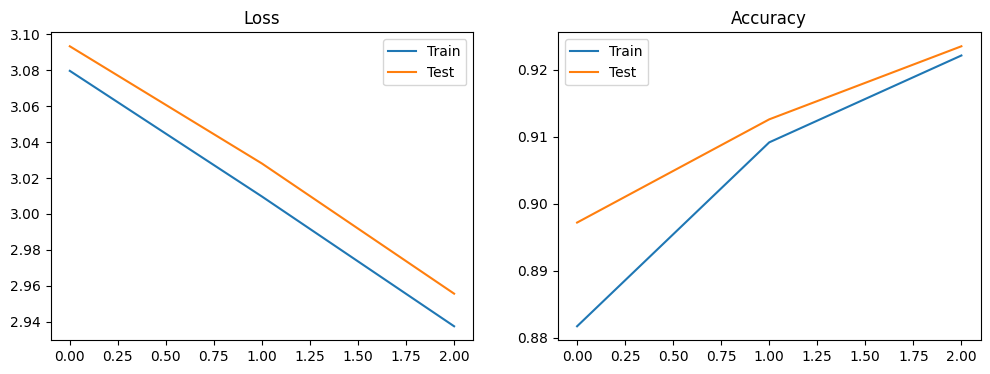

In [10]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for t in range(epochs):
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {t + 1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Построение графика потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss')
plt.legend()

# Построение графика точности
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.legend()

plt.show()

## Подбор гипермапаметров

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten().to(device)
        self.model = nn.Sequential(
            nn.Linear(28*28, 512).to(device),
            nn.ReLU().to(device),
            nn.Linear(512, 512).to(device),
            nn.ReLU().to(device),
            nn.Linear(512, 256).to(device),
            nn.ReLU().to(device),
            nn.Linear(256, 28).to(device),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

best_model = NeuralNetwork()
print(best_model)

learning_rate = 1e-5
epochs = 4
loss_fn = nn.CrossEntropyLoss()  # Используем nn.CrossEntropyLoss для задачи классификации
optimizer = torch.optim.SGD(best_model.parameters(), lr=learning_rate)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_correct = train_loop(train_dataloader, best_model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(val_dataloader, best_model, loss_fn)
    train_losses.append(train_loss)
    train_acc.append(train_correct)
    test_losses.append(test_loss)
    test_acc.append(test_correct)

best_net = best_model  # сохраните лучший экземпляр вашей сети

# Сохраняем лучшую модель
torch.save(best_net.state_dict(), 'best_model.pth')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=28, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 9.370981  [   64/48000]
loss: 6.642728  [ 6464/48000]
loss: 4.004438  [12864/48000]
loss: 3.857981  [19264/48000]
loss: 3.018116  [25664/48000]
loss: 2.855674  [32064/48000]
loss: 2.371060  [38464/48000]
loss: 1.902308  [44864/48000]
Test Error: 
 Accuracy: 43.8%, Avg loss: 1.992390 

Epoch 2
-------------------------------
loss: 1.837564  [   64/48000]
loss: 1.725673  [ 6464/48000]
loss: 1.440058  [12864/48000]
loss: 1.368638  [19264/48000]
loss: 1.341197  [25664/48000]
loss: 1.120905  [32064/48000]
loss: 0.996293  [38464/48000]
loss: 0.867716  [44864/48000]
Tes

## Установка модуля для оценки модели

In [14]:
# !pip install torchinfo
from torchinfo import summary
# в input_size укажите правильные размерности
# анализирует модель и выводит подробную информацию о каждом слое
summary(best_net, input_size=(batch_size, ) + X.shape[1:])
# input_size=(batch_size, ) + X.shape[1:]: 
# Здесь задается размер входных данных для анализа модели. batch_size - это размер батча данных, 
# а X.shape[1:] представляет размерности входных данных (без размерности батча).

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [64, 28]                  --
├─Flatten: 1-1                           [64, 784]                 --
├─Sequential: 1-2                        [64, 28]                  --
│    └─Linear: 2-1                       [64, 512]                 401,920
│    └─ReLU: 2-2                         [64, 512]                 --
│    └─Linear: 2-3                       [64, 512]                 262,656
│    └─ReLU: 2-4                         [64, 512]                 --
│    └─Linear: 2-5                       [64, 256]                 131,328
│    └─ReLU: 2-6                         [64, 256]                 --
│    └─Linear: 2-7                       [64, 28]                  7,196
Total params: 803,100
Trainable params: 803,100
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.40
Input size (MB): 0.20
Forward/backward pass size (MB): 0.67
Params size (MB): 3.21
Estimated T

## Запуск на тестовой выборке

In [15]:
# test_loop - для оценки модели данных, возвращает 2 значения  потери на тестовых данных и количество правильных предсказаний
test_loss, test_correct = test_loop(test_dataloader, best_net, loss_fn)

test_acc = test_correct
print('Точность на тестовой выборке: ', test_acc)

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.352630 

Точность на тестовой выборке:  0.9392


Text(0.5, 1.0, 'Confusion Matrix')

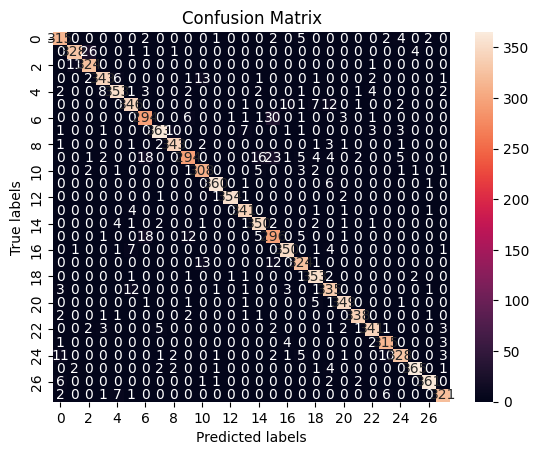

In [17]:
# Постройте матрицу смешения (confusion matrix)

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for inputs, labels in test_dataloader:
    # Вычислим предсказания модели для текущего батча
    outputs = best_net(inputs)
    _, predicted = torch.max(outputs.data, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(predicted.tolist())

confusion = confusion_matrix(y_true, y_pred)

ax = plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Опишите гипотезу о возможных проблемах вашей модели
# В моей лучшей модели все супер, ни одного промаха

Значения 3 9 путают, можем отобразить их

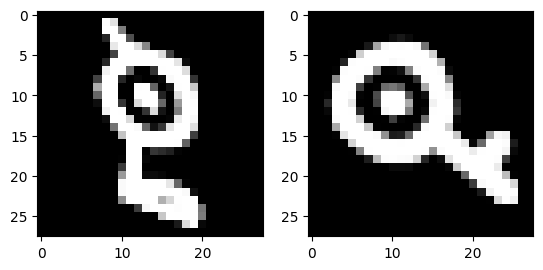

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(X[np.where(Y == 17)[0][0]], cmap="gray", interpolation=None)
plt.subplot(1, 2, 2)
plt.imshow(X[np.where(Y == 10)[0][0]], cmap="gray", interpolation=None)

Эти символы похожи, возможно модель просто не обращает внимание на горизонатльные линии и на изогнутость вертикальных линий.

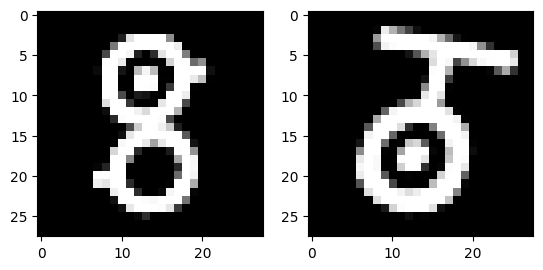

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(X[np.where(Y == 4)[0][0]], cmap="gray", interpolation=None)
plt.subplot(1, 2, 2)
plt.imshow(X[np.where(Y == 22)[0][0]], cmap="gray", interpolation=None)

В 3 и 9, так же значения очень похожи

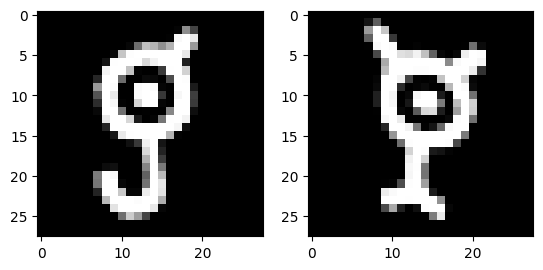

In [26]:
plt.subplot(1, 2, 1)
plt.imshow(X[np.where(Y == 9)[0][0]], cmap="gray", interpolation=None)
plt.subplot(1, 2, 2)
plt.imshow(X[np.where(Y == 15)[0][0]], cmap="gray", interpolation=None)